# Install dependences

# Run the image analysis - Step 1

# dict_1

In [3]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import torch
import re
import math
import random
from PIL import Image
%matplotlib inline
from sklearn import cluster
import numpy as np
import torch, torchvision
import mmdet
import glob
import os
from PIL import Image, ImageDraw
from distinctipy import distinctipy
from scipy.interpolate import interp1d
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.kpca import KPCA
from pyod.models.kde import KDE
from sklearn.cluster import AffinityPropagation
from scipy.interpolate import splrep, sproot, splev
from scipy.cluster import vq
import PIL
from Plot2Spec_materials_eyes.src.plot_data_extraction.plot_digitizer import PlotDigitizer
from Plot2Spec_materials_eyes.src.plot_data_extraction.SpatialEmbeddings.src.utils import transforms as my_transforms
from Plot2Spec_materials_eyes.src.plot_data_extraction.evaluation import PlotEvaluator
from Plot2Spec_materials_eyes.src.plot_data_extraction.utils import GenerateTestData, dict2class
from Plot2Spec_materials_eyes.src.axis_alignment.utils import dict2class, AxisAlignment
from Plot2Spec_materials_eyes.src.plot_data_extraction.optical_flow import OpticalFlow
from sklearn import preprocessing
import lmdb
from sklearn.preprocessing import MinMaxScaler
import mmdet

In [4]:
def recognize_text(img_path):
    '''loads an image and recognizes text.'''

    reader = easyocr.Reader(['en'])
    return reader.readtext(img_path)

In [5]:
def overlay_ocr_text(img_path):

    '''loads an image, recognizes text, and overlays the text on the image.'''
    points = []
    labels=[]
    # loads image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#BGR2HSV)#)


    # recognize text
    result = recognize_text(img_path)

    # if OCR prob is over 0.5, overlay bounding box and text
    for (bbox, text, prob) in result:
      if len(text)>2:
        if text[0].isalpha() == True:
          if text[:10] != 'Wavelength':
            if text[:2] != 'nm':
              if '00' not in text:
                if prob >= 0.4:
                  labels.append(text)#.split()[0])
                  # get top-left and bottom-right bbox vertices
                  (top_left, top_right, bottom_right, bottom_left) = bbox
                  top_left = (int(top_left[0]), int(top_left[1]))
                  bottom_right = (int(bottom_right[0]), int(bottom_right[1]))
                  points.append(bbox)
                  # create a rectangle for bbox display
                  cv2.rectangle(img=img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=10)

                  # put recognized text
                  cv2.putText(img=img, text=text, org=(top_left[0], top_left[1] - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=8)
      #print(labels)
    return labels, points

In [16]:
def get_label_colors(image_path, i, labels, points):
    lab = labels[i]
    (top_left, _, bottom_right, _) = points[i]

    # Open the image using PIL
    with Image.open(image_path) as im:
        # Crop the image correctly
        cropped_image = im.crop((top_left[0] - 100, (bottom_right[1] + top_left[1]) / 2 - 2, top_left[0], (bottom_right[1] + top_left[1]) / 2 + 2))

    # Convert the cropped image to RGB and save it
    cropped_image_rgb = cropped_image.convert("RGB")
    cropped_image_rgb.save('cropped_image.png')

    # Read the saved image using OpenCV
    src = cv2.imread('cropped_image.png')
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

    # Process pixels
    pxls = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = tuple(image[i, j])
            if pixel < (250, 250, 250):
                pxls.append(pixel)

    # Compute the mean of the pixels, if any pixels were added
    if pxls:
        return lab, np.mean(pxls, axis=0)
    else:
        return lab, None

In [17]:
def create_dictionary(image_path):

  labels, points= overlay_ocr_text(image_path)
  labs=[]
  rgb=[]
  for i in range(len(labels)):
    labelaki, color = get_label_colors(image_path, i, labels, points)
    labs.append(labelaki)
    rgb.append(color)
  res = dict(map(lambda i,j : (i,j) , labs, rgb))
  return res

In [18]:
def main(path):
  #for filename in os.listdir(folder_path): #make to look only on image files
    #print(im_id)
    #print(filename)
    dict_1=create_dictionary(path)
    dt_keys= dict_1.keys()
    try:
      for i in dt_keys:
        if len(set(dict_1[i])) == 1:
          dict_1.pop(i, None)
    except:
      pass
    print(dict_1)
    #print(res)
    return dict_1


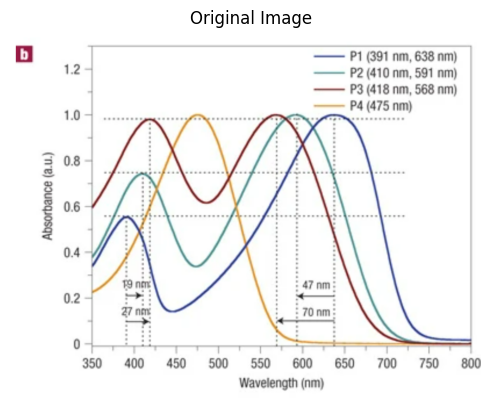

In [19]:
# load image
imageObj = cv2.imread('abs_image_example.png')
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow( cv2.cvtColor(imageObj, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
path = "C:/Users/kvriz/Desktop/Polymer_electronics_multimodal_database/Screenshot 2022-11-20 172619.png" #"/content/Screen Shot 2022-11-21 at 12.19.22 PM.png" # "/content/Screenshot 2022-11-20 172619.png"
dict_1 = main(path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


{'P1 (391 nr, 638 nm)': array([134.76284585, 143.45059289, 180.30039526]), 'P2 (410 nm, 591 nm)': array([168.82 , 195.176, 195.172]), 'P3 (418 nm, 568 nm)': array([165.82591093, 129.92712551, 128.5465587 ]), 'P4 (475 nm)': array([219.21666667, 196.925     , 161.41666667])}


In [21]:
dict_1

{'P1 (391 nr, 638 nm)': array([134.76284585, 143.45059289, 180.30039526]),
 'P2 (410 nm, 591 nm)': array([168.82 , 195.176, 195.172]),
 'P3 (418 nm, 568 nm)': array([165.82591093, 129.92712551, 128.5465587 ]),
 'P4 (475 nm)': array([219.21666667, 196.925     , 161.41666667])}

# dict_4

In [22]:
colors = distinctipy.get_colors(30)

In [23]:
axis_align_opt = {
    # region detection
    "config_file": "Plot2Spec_materials_eyes/checkpoints/axis_alignment/fcos_x101_64x4d_fpn_gn-head_mstrain_640-800_2x_coco.py",
    "checkpoint_file": "Plot2Spec_materials_eyes/checkpoints/axis_alignment/epoch_200.pth",
    "refinement": True,
    # tick detection
    "cuda": False,
    "canvas_size": 1280,
    "mag_ratio": 1.5,
    "poly": False,
    "text_threshold": 0.1,
    "low_text": 0.5,
    "link_threshold": 0.7,
    "show_time": False,
    "refine": True,
    "trained_model": 'Plot2Spec_materials_eyes/checkpoints/axis_alignment/craft_mlt_25k.pth',
    "refiner_model": 'Plot2Spec_materials_eyes/checkpoints/axis_alignment/craft_refiner_CTW1500.pth',
    # tick recognition
    "workers": 0,
    "saved_model": "Plot2Spec_materials_eyes/checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth",
    "batch_max_length": 25,
    "imgH": 32,
    "imgW": 100,
    "rgb": False,
    "character": "0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive": False,
    "PAD": True,
    "Transformation": "TPS",
    "FeatureExtraction": "ResNet",
    "SequenceModeling": "BiLSTM",
    "Prediction": "Attn",
    "num_fiducial": 20,
    "input_channel": 1,
    "output_channel": 512,
    "hidden_size": 256,
}


In [24]:
# Identifying the axis ticks and numbers 
path = "C:/Users/kvriz/Desktop/Polymer_electronics_multimodal_database/conjugated_ECPs/uv_vis_automated/Nature Materials, 2008, 7, 795–799/abs_spectra" # "conjugated_ECPs/uv_vis_automated/Polymer Chemistry, 11, 2173 – 2181, 2020/abs_spectra/"
axis_alignment = AxisAlignment(axis_align_opt)
axis_alignment.load_data(path)
img, plot_bbox, results, results_all = axis_alignment.run(0)

build plot detector ...
Use load_from_local loader


c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from Plot2Spec_materials_eyes/checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth


c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\mmdet\datasets\utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [25]:
[int(tick[0][:3]) for tick in results]

[400, 350, 500, 550, 700, 750]

In [26]:
for idx, tick in enumerate(results):
    print(idx, tick[0])

0 4001
1 350
2 500
3 550
4 7001
5 750


In [27]:
def read_img(path):
  img = cv2.imread(path)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.

def write_img(img, path):
  img = (img * 255).astype(np.uint8)
  print(img.shape, img.dtype)
  Image.fromarray(img).save(path)

def dilate_image(image_path):
  img = read_img(image_path)
  img = np.abs(img - 1)
  print(img.mean())
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  img = cv2.dilate(img, kernel, iterations=1)
  img = np.abs(img - 1)
  write_img(img, image_path)
  return img

In [28]:
background_opt = {
    "cuda": False,
    "display": False,
    "save": True,
    "save_dir": "./exp/",
    "root": "Plot2Spec_materials_eyes/data/input_plot_extraction/leftImg8bit/",
    "data_type": "test",
    "mode": "abs_spectra",
    "num_workers": 10,
    "model_file": "Plot2Spec_materials_eyes/checkpoints/plot_data_extraction/lanenet/deeplab_all_checkpoint/0999_checkpoint.ckpt",
    "checkpoint_path": "Plot2Spec_materials_eyes/checkpoints/plot_data_extraction/checkpoint_0999.pth",

    "dataset": {
        'name': 'cityscapes',
        'kwargs': {
            'root_dir': "Plot2Spec_materials_eyes/data/input_plot_extraction",
            'type': 'test',
            'transform': my_transforms.get_transform([
                {
                    "name": "CustomResizePad",
                    "opts": {
                        'keys': ('image', 'instance','label'),
                        "is_test": True,
                    },
                },
                {
                    'name': 'ToTensor',
                    'opts': {
                        'keys': ('image', 'instance', 'label'),
                        'type': (torch.FloatTensor, torch.ByteTensor, torch.ByteTensor),
                    }
                },
                {
                    'name': 'Normalize',
                    'opts': {
                        'keys': ('image'),
                        'p': -1,
                    }
                },
            ]),
        }
    },

    "model": {
        'name': 'branched_erfnet',
        'kwargs': {
            'num_classes': [3, 1],
        }
    }
}

In [ ]:
plot_digitizer = PD() # PlotDigitizer()
plot_digitizer.load_seg("spatialembedding", background_opt)
img_id =0
plot_digitizer.predict_from_ins_seg(img_id, denoise=False)
#plot_digitizer.img_name
res_map = plot_digitizer.result_dict['visual']
img_rgb, seg_map, ins_map = res_map['img_rgb'], res_map['seg_map'], res_map['ins_map']
masked_img = seg_map[..., None] * img_rgb


centroid, labels = vq.kmeans2(masked_img.reshape((-1, 3)), 5, 50)

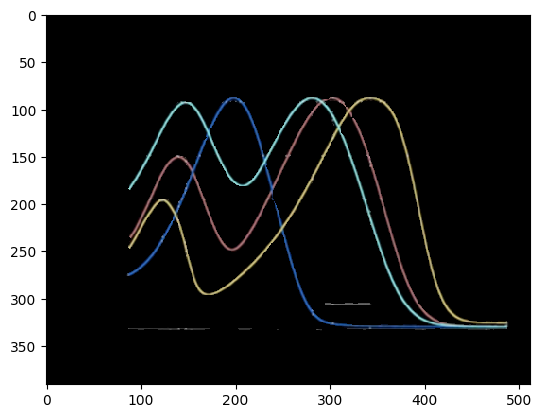

In [487]:
#ticks = [tick[0] for tick in results]
plt.imshow(masked_img, interpolation='none')#, extent=[320,1000,400,0])

In [539]:
data

[(array([170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
         183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
         196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
         209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
         222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
         235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
         248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
         261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
         274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
         287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
         300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
         313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
         326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
         339, 340, 341, 342, 343, 344,

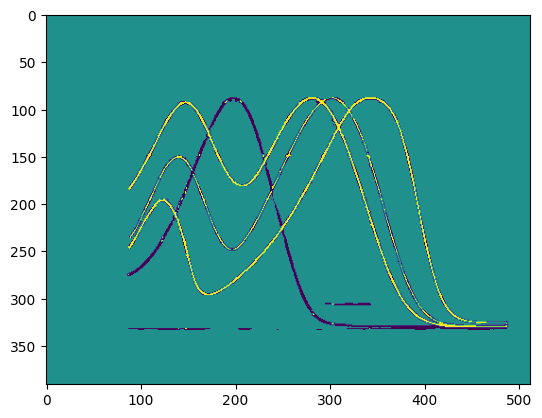

In [488]:
new_labels = labels.reshape(masked_img.shape[:-1])
plt.imshow(new_labels)

In [ ]:
plot_digitizer = PlotDigitizer()
plot_digitizer.load_seg("spatialembedding", background_opt)
img_id =0
plot_digitizer.predict_from_ins_seg(img_id, denoise=False)
#plot_digitizer.img_name
res_map = plot_digitizer.result_dict['visual']
img_rgb, seg_map, ins_map = res_map['img_rgb'], res_map['seg_map'], res_map['ins_map']
masked_img = seg_map[..., None] * img_rgb

In [523]:
from Plot2Spec_materials_eyes.src.plot_data_extraction.utils import GenerateTestData, dict2class, Segmap2Lines
"""
grid search for the best parameter setting:
 - match_threshold (i.e. change the coefficient for different losses)
 - start position
"""
def Run(plot_digitizer, img_id):
    plot_digitizer.predict_from_ins_seg(img_id)
    ins_map = plot_digitizer.result_dict["visual"]["ins_map"]
    img_gray = plot_digitizer.result_dict["visual"]["img_gray"]
    img_rgb = plot_digitizer.result_dict["visual"]["img_rgb"]
    seg_map = plot_digitizer.result_dict["visual"]["seg_map"]
    seg_plots = Segmap2Lines(ins_map)
    plot_digitizer.find_init_posi()
    plot_evaluator = PlotEvaluator(img_rgb, img_gray, seg_map)
    match_thresholds = [0.8,0.85,0.9,0.95,0.97,0.99]
    start_ids = plot_digitizer.result_dict["data"]["start_ids"]
    scores, param_space, line_sets = plot_evaluator.param_search(match_thresholds, start_ids)
    mean_score = np.mean(scores, axis=1)
    s, m = param_space[np.argmax(mean_score)]
    line_set = line_sets[np.argmax(mean_score)]
    result = {}
    result["img_name"] = plot_digitizer.img_name
    result["start_posi"] = s
    result["match_threshold"] = m
    result["pred_line_set"] = line_set
    result["seg_line_set"] = seg_plots
    result["visual"] = [img_rgb, seg_map, ins_map]
    return result

In [ ]:
result = Run(plot_digitizer, 0)

In [ ]:
x_bias, y_bias = list(plot_bbox)[:2]
x_min, y_min, x_max, y_max = int(list(plot_bbox)[0]), list(plot_bbox)[1], int(list(plot_bbox)[2]), list(plot_bbox)[3]
x_count = x_max-x_min+1
norm_ts = np.linspace(0,x_max-x_min, x_count)
y_resize_ratio = (y_max-y_min)/result["visual"][0].shape[0]

plot_ts, plot_lines = result["pred_line_set"]["plot"]
norm_ts_pred = np.linspace(min(plot_ts), max(plot_ts), x_count)

In [530]:
result["pred_line_set"]["plot"]

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [538]:
result['pred_line_set']["plot"]

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

0.02164830259682731
(391, 512, 3) uint8


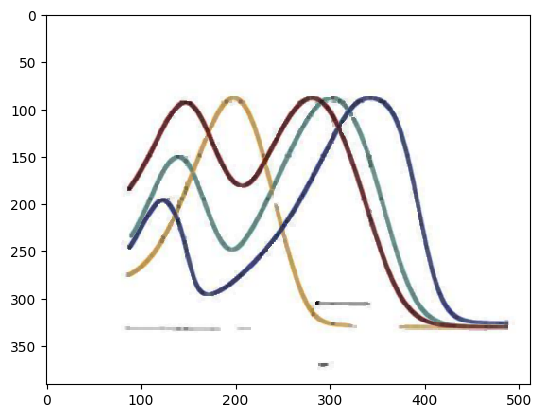

In [500]:
masked_img[np.where((masked_img==[0,0,0]).all(axis=2))] = [1,1,1]
im=Image.fromarray((255*masked_img).astype(np.uint8))
im.save('spec.jpeg')
new = dilate_image('spec.jpeg')

plt.imshow(new, interpolation='none')#, extent=[320,1000,400,0])#
plt.savefig('dilated_im.png')

0.022006305319442355
(391, 512, 3) uint8


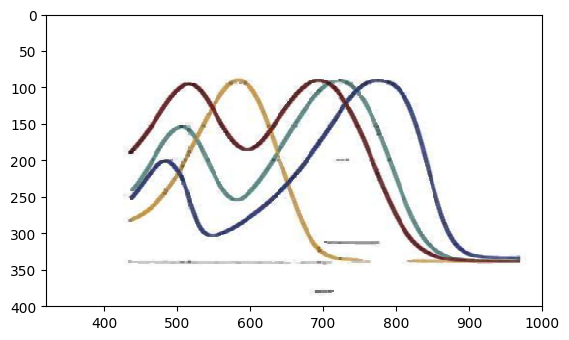

In [493]:
masked_img[np.where((masked_img==[0,0,0]).all(axis=2))] = [1,1,1]
im=Image.fromarray((255*masked_img).astype(np.uint8))
im.save('spec.jpeg')
new = dilate_image('spec.jpeg')

plt.imshow(new, interpolation='none', extent=[320,1000,400,0])#
plt.savefig('dilated_im.png')

In [501]:
img = PIL.Image.open('dilated_im.png')
img.convert('RGB')
paletted = img.convert('P', palette=PIL.Image.ADAPTIVE, colors=10)
palette = paletted.getpalette()
colors = paletted.getcolors()
colors

[(293688, 0),
 (2634, 1),
 (2491, 2),
 (1942, 3),
 (1820, 4),
 (1699, 5),
 (1068, 6),
 (650, 7),
 (606, 8),
 (602, 9)]

In [58]:
def derivative(x_data, y_data):
    N = len(x_data)
    delta_x = [x_data[i+1] - x_data[i] for i in range(N - 1)]
    x_prim = [(x_data[i+1] + x_data[i]) / 2. for i in range(N - 1)]
    y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]
    return x_prim, y_prim

In [59]:
ticks = [tick[0] for tick in results]
ticks[0]

'4001'

1942
1820
curvature 322.51525821596243


C:\Users\kvriz\AppData\Local\Temp\ipykernel_27412\2540409091.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


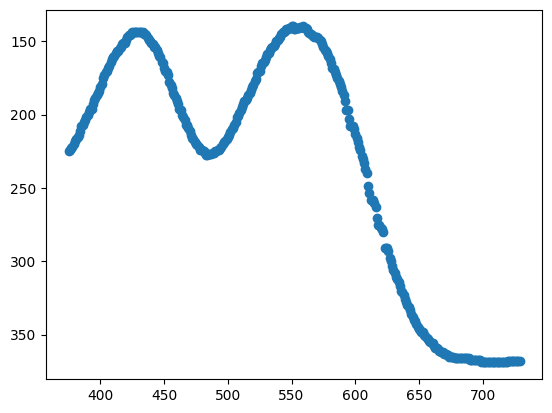

C:\Users\kvriz\AppData\Local\Temp\ipykernel_27412\2540409091.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]


1699
curvature 327.4054794520548


c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


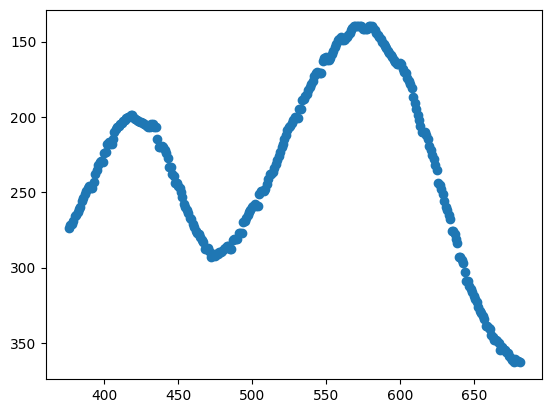

C:\Users\kvriz\AppData\Local\Temp\ipykernel_27412\2540409091.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]
C:\Users\kvriz\AppData\Local\Temp\ipykernel_27412\2540409091.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


1068
curvature 274.31455897980874


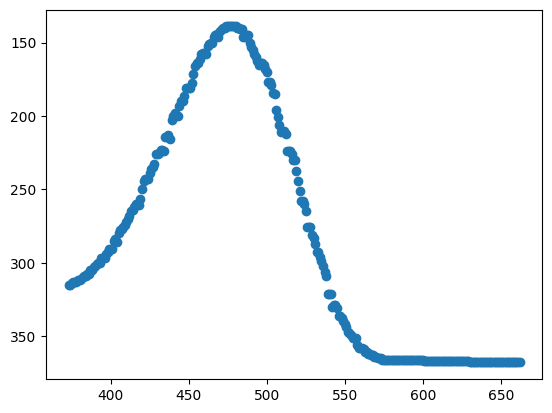

650


C:\Users\kvriz\AppData\Local\Temp\ipykernel_27412\2540409091.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]


606
curvature 319.8667953667954


c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\kvriz\miniconda3\envs\poly_agent\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


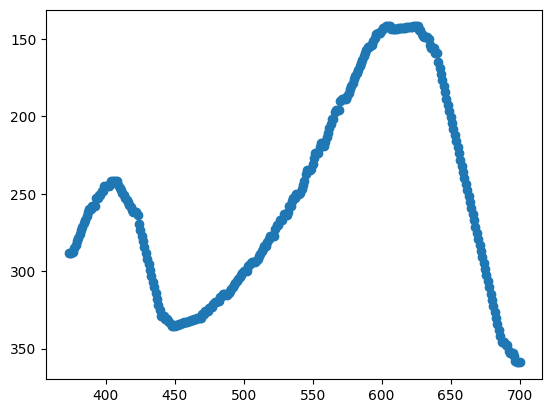

In [544]:
import pandas as pd

def check_img(i):

  y, x = np.where(np.asarray(paletted) == i)
  curve_color = palette[i*3:i*3+3]
  #x=x+np.min([int(tick[0]) for tick in results])
  df=pd.concat([pd.DataFrame(x),pd.DataFrame(y)], axis=1)
  if df.shape[0] <  2000: #1000
    if df.shape[0] >  602:
      print(df.shape[0])

      Y = df.values# y.reshape(1, 1)#.values#.reshape(-1, 1)
      clf = KNN(n_neighbors=10, radius=0.3, contamination=0.2) #AffinityPropagation(damping=0.8, max_iter=200, convergence_iter=25)#KDE(contamination=0.02, algorithm='auto')#random_state=0, contamination=0.02)
      clf.fit(Y)
      outliers = clf.predict(Y)
      out = np.where(outliers==1)
      into = np.where(outliers==0)
      if np.mean(clf.decision_scores_)< 7:
        if len(out[0])>0:

          x1 =  x[into]#+  # change to standard np.arrange()np.arange(350, 700, 10) #
          y1 = y[into]
          x_bis, y_bis = derivative(*derivative(x1, y1))
          print('curvature',  np.mean(x_bis) )
          if np.mean(x_bis)>200:
            #print(x1.min())
            #plt.scatter(x1 , y1)
            f = interp1d(x1, y1, fill_value="extrapolate")  #fill_value="extrapolate"

            #wavelength = np.arange(450, 650,1)
            #try:
            #  plt.scatter(wavelength , f(wavelength))
            #except:
            wavelength = np.arange(x1.min(), x1.max(),1)  #
            plt.gca().invert_yaxis()
            plt.scatter(wavelength+x_bias+50 , f(wavelength))
            #print(np.count_nonzero(np.isnan(y)))

            #y = y[np.logical_not(np.isnan(y))]
            #print(np.var(y))
            plt.show()
            return wavelength, f(wavelength), curve_color # np.array([wavelength, y])
        
data = []
for i in range(10):
  new= check_img(i)
  #data.append(new)
  try:
    if new != None:
      data.append(new)
  except:
    pass
   #

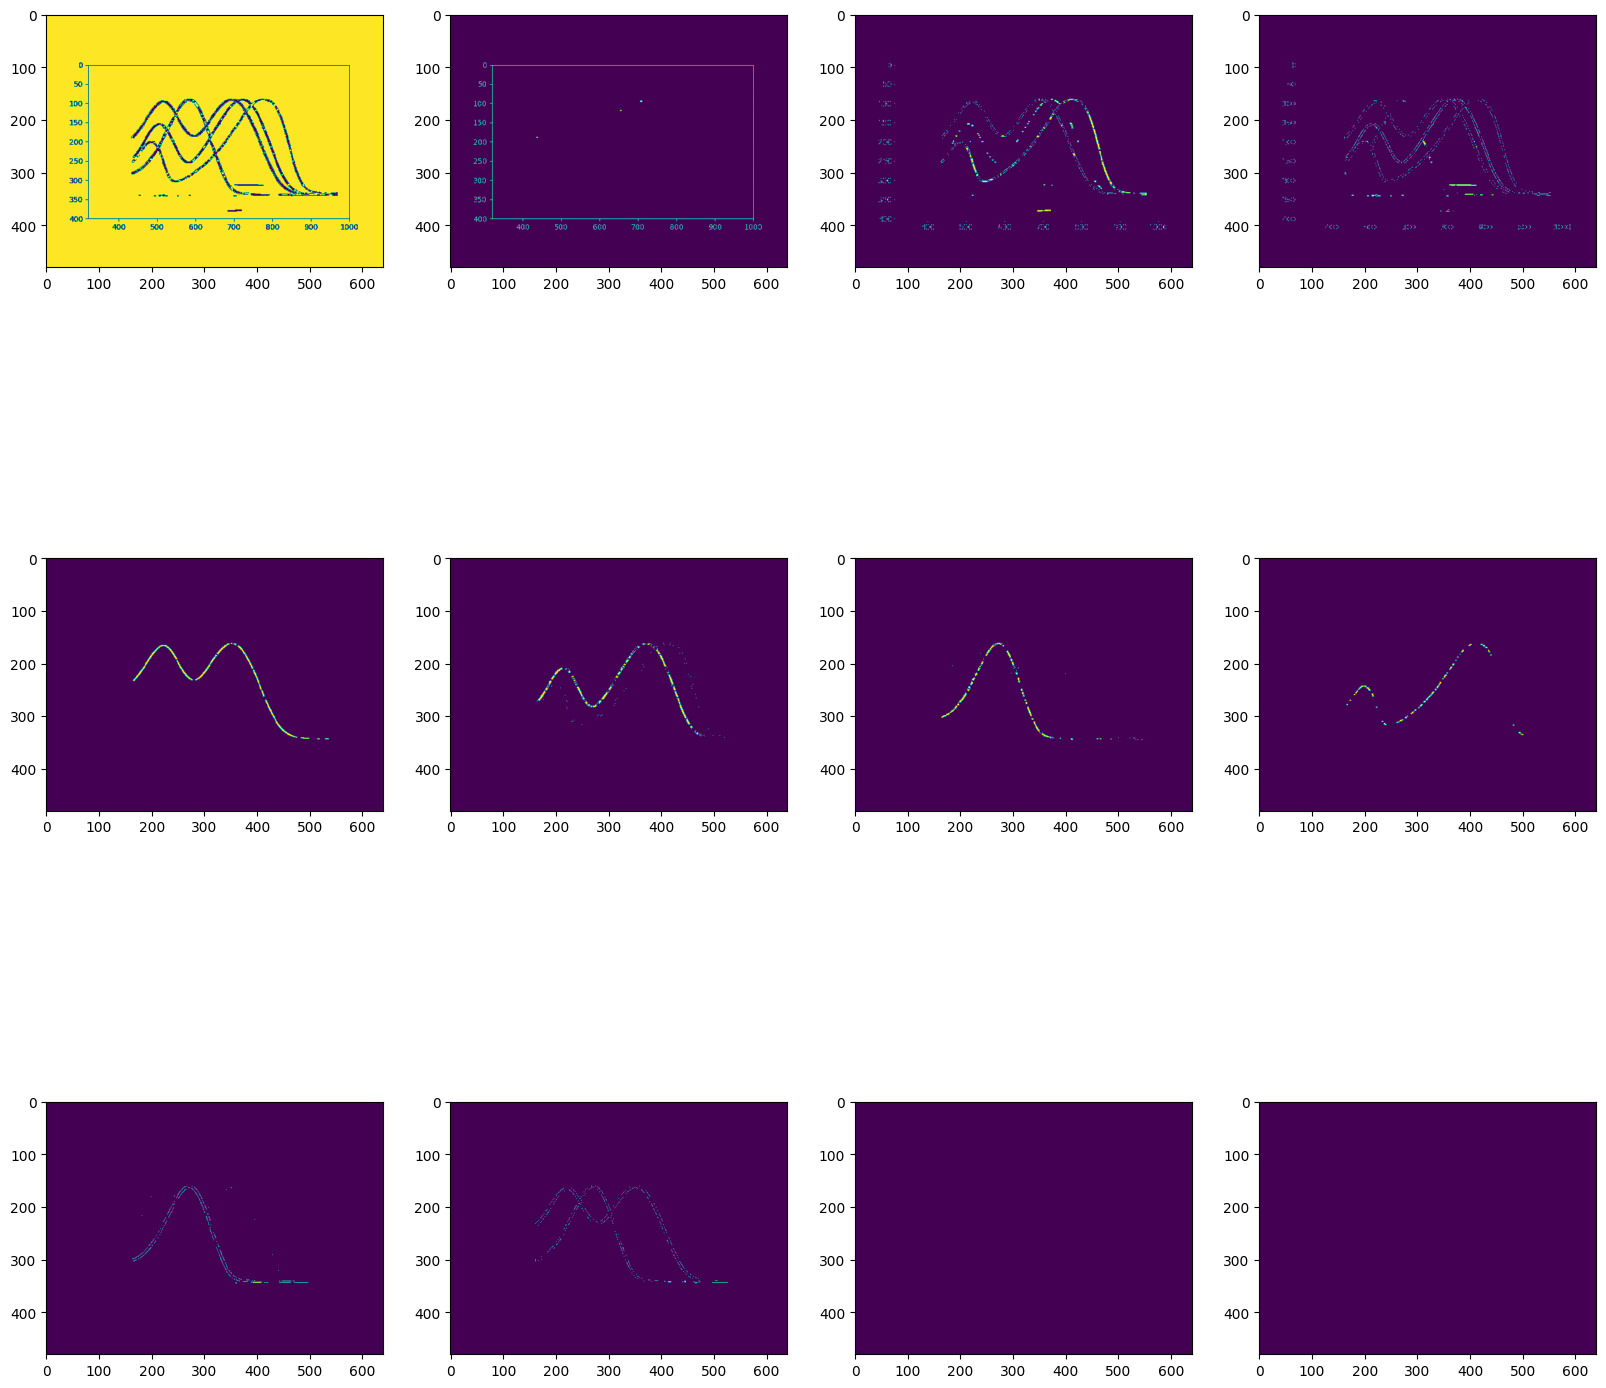

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(np.asarray(paletted) == i)#, cmap='gray')

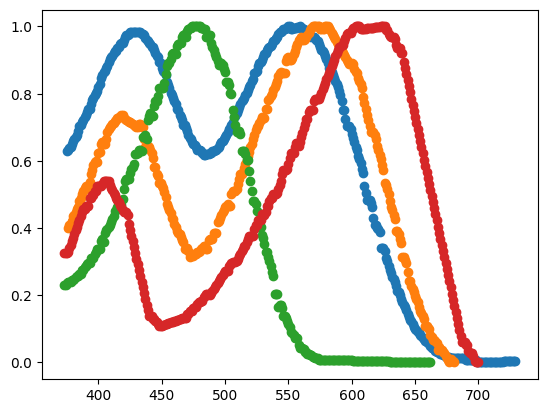

In [548]:
min_max_scaler = MinMaxScaler()
df1 = pd.concat([pd.DataFrame(data[0][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[0][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
df1.dropna(axis=0)#
df2 = pd.concat([pd.DataFrame(data[1][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[1][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
df2.dropna(axis=0)#
df3 = pd.concat([pd.DataFrame(data[2][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[2][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
df3.dropna(axis=0)#
df4 = pd.concat([pd.DataFrame(data[3][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[3][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
df4.dropna(axis=0)#
plt.scatter(df1.wavelength+x_bias+50, df1.absor.values, label=i)
plt.scatter(df2.wavelength+x_bias+50, df2.absor.values, label=i) #-df2.wavelength.min()+350
plt.scatter(df3.wavelength+x_bias+50, df3.absor.values, label=i)
plt.scatter(df4.wavelength+x_bias+50, df4.absor.values, label=i)


In [148]:
x_bias, y_bias = list(plot_bbox)[:2]
x_min, y_min, x_max, y_max = int(list(plot_bbox)[0]), list(plot_bbox)[1], int(list(plot_bbox)[2]), list(plot_bbox)[3]
x_count = x_max-x_min+1
norm_ts = np.linspace(0,x_max-x_min, x_count)
y_resize_ratio = (y_max-y_min)/result["visual"][0].shape[0]

plot_ts, plot_lines = result["pred_line_set"]["plot"]
norm_ts_pred = np.linspace(min(plot_ts), max(plot_ts), x_count)

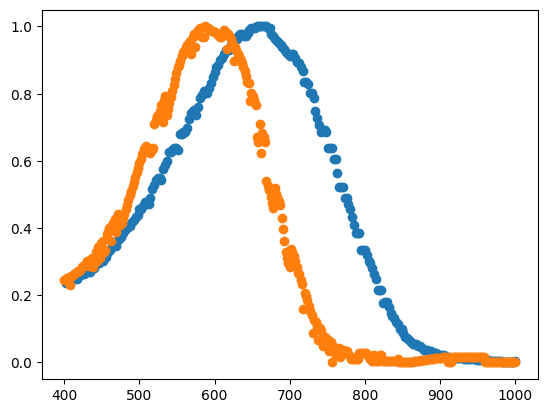

In [90]:
df1 = pd.concat([pd.DataFrame(data[2][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[2][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
df2 = pd.concat([pd.DataFrame(data[4][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*data[4][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
plt.scatter(np.linspace(400, 1000, len(df1.absor.values)), df1.absor.values, label=i)
plt.scatter(np.linspace(400, 1000, len(df2.absor.values)), df2.absor.values, label=i)

In [280]:
dict_4 = dict(map(lambda i,j : (i,j) , [('plot_%s'%i) for i in range(len(data))],data))
dict_4

{'plot_0': (array([166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
         179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
         192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
         205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
         218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
         231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
         244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
         257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
         270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
         283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
         296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
         309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
         322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
         335, 336, 337, 338,

# dict_2

In [481]:
im = Image.open("dilated_im.png")
im.convert('RGB')
width, height = im.size
width+x_bias, height

(794.0, 480)

In [309]:
curve_colors=[]
plot_index = []
for k in range(len(data)):
  x,y = data[k][0][1:]-350, data[k][1][1:]
  ls = [(int(i), int(j)) for i,j in zip(x, y)]
  pxls=[]
  for i,j in enumerate(ls):
    #print(i,j)
    if im.getpixel((int(ls[i][0]), int(ls[i][1])  ))[:-1] < (250, 250, 250) :
      if im.getpixel((int(ls[i][0]), int(ls[i][1])  ))[:-1] > (0, 0, 0) :
        pxls.append(im.getpixel((int(ls[i][0]), int(ls[i][1])))[:-1])
        plot_index.append(k)
  curve_colors.append(np.mean(pxls, axis=0))
  #print(np.mean(pxls, axis=0))
cleanedList = [x for x in curve_colors if str(x) != 'nan']
set(plot_index)

{0, 1, 2, 3}

In [310]:
dict_2 = dict(map(lambda i,j : (i,j) , [list(dict_4.keys())[i] for i in set(plot_index)],cleanedList))

In [332]:
data[3][2]

[53, 57, 94]

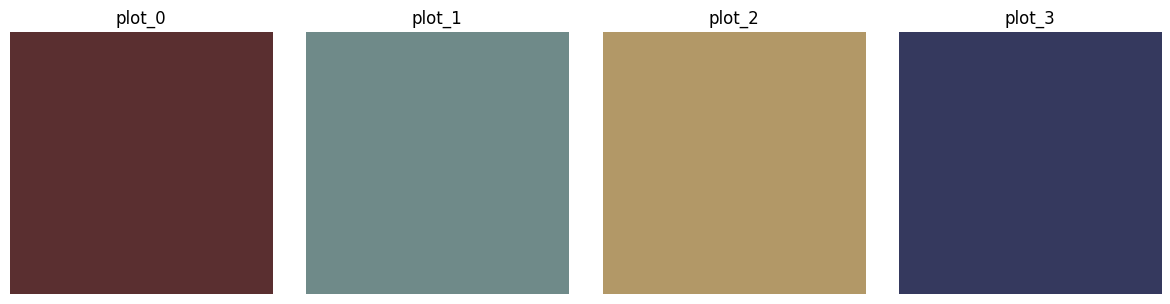

In [333]:
import matplotlib.pyplot as plt
import numpy as np

# Given color data
colors = {
    'plot_0': np.array(data[0][2]),
    'plot_1': np.array(data[1][2]),
    'plot_2': np.array(data[2][2]),
    'plot_3': np.array(data[3][2])
}

# Normalize the RGB values to the range [0, 1] for matplotlib
normalized_colors = {key: value / 255 for key, value in colors.items()}

# Create a figure with subplots
fig, axs = plt.subplots(1, len(normalized_colors), figsize=(12, 3))

# Display each color
for ax, (label, color) in zip(axs, normalized_colors.items()):
    ax.set_title(label)
    ax.imshow([[color]])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [345]:
dict_2 = {'plot_0': np.array(data[0][2]),
 'plot_1': np.array(data[1][2]),
 'plot_2': np.array(data[2][2]),
 'plot_3': np.array(data[3][2])}
dict_2

{'plot_0': array([90, 47, 48]),
 'plot_1': array([111, 138, 137]),
 'plot_2': array([178, 152, 103]),
 'plot_3': array([53, 57, 94])}

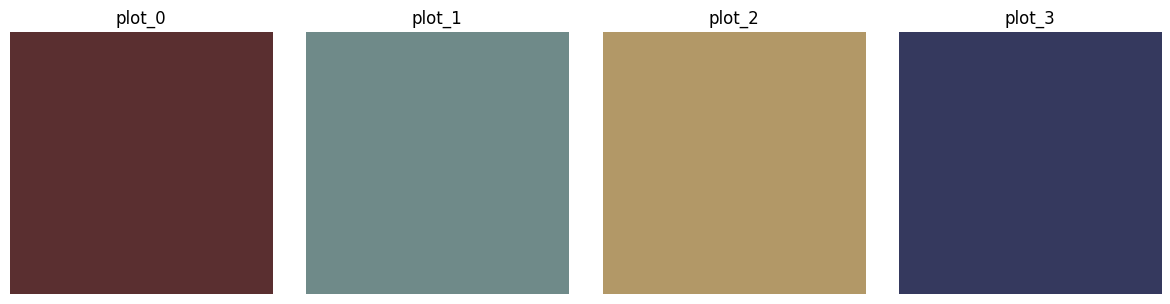

In [355]:
import matplotlib.pyplot as plt
import numpy as np

# Given color data
colors = {
    'plot_0': dict_2['plot_0'],
    'plot_1': dict_2['plot_1'],
    'plot_2': dict_2['plot_2'],
    'plot_3': dict_2['plot_3']
}

# Normalize the RGB values to the range [0, 1] for matplotlib
normalized_colors = {key: value / 255 for key, value in colors.items()}
dict_2_norm = normalized_colors
# Create a figure with subplots
fig, axs = plt.subplots(1, len(normalized_colors), figsize=(12, 3))

# Display each color
for ax, (label, color) in zip(axs, normalized_colors.items()):
    ax.set_title(label)
    ax.imshow([[color]])
    ax.axis('off')

plt.tight_layout()
plt.show()


# dict_3

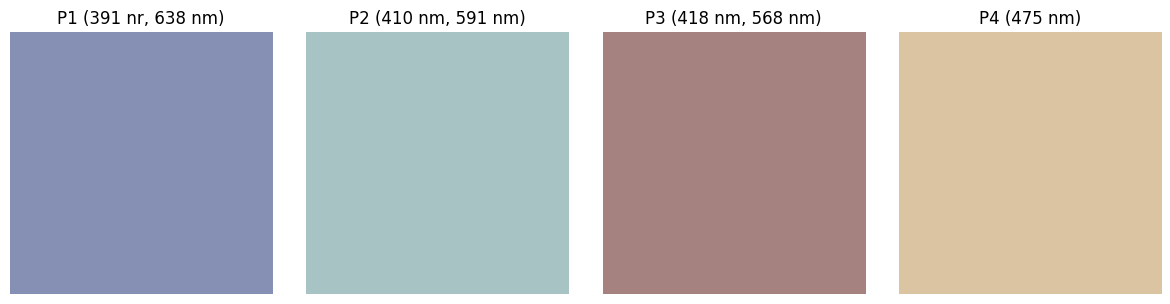

In [356]:
import matplotlib.pyplot as plt
import numpy as np

# Given color data
colors = {
    'P1 (391 nr, 638 nm)': dict_1['P1 (391 nr, 638 nm)'],
    'P2 (410 nm, 591 nm)': dict_1['P2 (410 nm, 591 nm)'],
    'P3 (418 nm, 568 nm)': dict_1['P3 (418 nm, 568 nm)'],
    'P4 (475 nm)': dict_1['P4 (475 nm)']
}

# Normalize the RGB values to the range [0, 1] for matplotlib
normalized_colors = {key: value / 255 for key, value in colors.items()}
dict_1_norm = normalized_colors
# Create a figure with subplots
fig, axs = plt.subplots(1, len(normalized_colors), figsize=(12, 3))

# Display each color
for ax, (label, color) in zip(axs, normalized_colors.items()):
    ax.set_title(label)
    ax.imshow([[color]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [357]:
dict_1_norm 

{'P1 (391 nr, 638 nm)': array([0.52848175, 0.56255134, 0.70706037]),
 'P2 (410 nm, 591 nm)': array([0.66203922, 0.76539608, 0.76538039]),
 'P3 (418 nm, 568 nm)': array([0.65029769, 0.50951814, 0.50410415]),
 'P4 (475 nm)': array([0.8596732 , 0.7722549 , 0.63300654])}

In [358]:
dict_2_norm 

{'plot_0': array([0.35294118, 0.18431373, 0.18823529]),
 'plot_1': array([0.43529412, 0.54117647, 0.5372549 ]),
 'plot_2': array([0.69803922, 0.59607843, 0.40392157]),
 'plot_3': array([0.20784314, 0.22352941, 0.36862745])}

In [360]:
from scipy.optimize import linear_sum_assignment
def color_distance(color1, color2):
    return np.linalg.norm(color1 - color2)

# Calculate the distance matrix between all color pairs
distance_matrix = np.zeros((len(dict_1_norm ), len(dict_2_norm )))

dict1_keys = list(dict_1_norm.keys())
dict2_keys = list(dict_2_norm.keys())

for i, color1 in enumerate(dict_1_norm .values()):
    for j, color2 in enumerate(dict_2_norm.values()):
        distance_matrix[i, j] = color_distance(color1, color2)

# Use the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(distance_matrix)

# Creating the dictionary for the optimal pairing
optimal_pairing = {dict1_keys[i]: dict2_keys[j] for i, j in zip(row_ind, col_ind)}

optimal_pairing # dict_3

{'P1 (391 nr, 638 nm)': 'plot_3',
 'P2 (410 nm, 591 nm)': 'plot_1',
 'P3 (418 nm, 568 nm)': 'plot_0',
 'P4 (475 nm)': 'plot_2'}

# save uv_vis to csv

In [477]:
dict_4['plot_1']

(array([167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
        245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
        258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
        271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
        284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
        297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
        310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
        323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
        336, 337, 338, 339, 340, 341, 342, 343, 344

In [362]:
new=[]
for i in optimal_pairing.keys():
  #print(dict_4[dict_3[i]])
  new.append(dict_4[optimal_pairing[i]])
new_dict = dict(map(lambda i,j : (i,j) , optimal_pairing.keys(),new))

In [478]:
new_dict['P1 (391 nr, 638 nm)']

(array([182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
        221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
        247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
        260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
        273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
        286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
        299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
        312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
        338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
        351, 352, 353, 354, 355, 356, 357, 358, 359

In [139]:
# convert absorption from 0-1
min_max_scaler = preprocessing.MinMaxScaler()


In [140]:
path_save= "."# "/content/uv_vis_automated/Adv. Mater., 20, 2772-2776, 2008"

In [386]:
dict_1_norm[list(new_dict.keys())[0]]

array([0.52848175, 0.56255134, 0.70706037])

In [379]:
new_dict.keys() # .keys()
list(new_dict.keys())[0]

'P1 (391 nr, 638 nm)'

In [396]:
list(dict_1_norm['P1 (391 nr, 638 nm)'])

[0.5284817484305976, 0.5625513446485314, 0.7070603735565373]

In [415]:
x_bias, y_bias = list(plot_bbox)[:2]
x_min, y_min, x_max, y_max = int(list(plot_bbox)[0]), list(plot_bbox)[1], int(list(plot_bbox)[2]), list(plot_bbox)[3]
x_count = x_max-x_min+1
norm_ts = np.linspace(0,x_max-x_min, x_count)
x_bias

154.0

In [430]:
np.min([int(tick[0][:3]) for tick in results])
int(list(plot_bbox)[0])

154

In [428]:
norm_ts = np.linspace(0,x_max-x_min, x_count)
norm_ts

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [467]:
np.linspace(350,800, len(df.wavelength.values))

array([350.        , 351.82926829, 353.65853659, 355.48780488,
       357.31707317, 359.14634146, 360.97560976, 362.80487805,
       364.63414634, 366.46341463, 368.29268293, 370.12195122,
       371.95121951, 373.7804878 , 375.6097561 , 377.43902439,
       379.26829268, 381.09756098, 382.92682927, 384.75609756,
       386.58536585, 388.41463415, 390.24390244, 392.07317073,
       393.90243902, 395.73170732, 397.56097561, 399.3902439 ,
       401.2195122 , 403.04878049, 404.87804878, 406.70731707,
       408.53658537, 410.36585366, 412.19512195, 414.02439024,
       415.85365854, 417.68292683, 419.51219512, 421.34146341,
       423.17073171, 425.        , 426.82926829, 428.65853659,
       430.48780488, 432.31707317, 434.14634146, 435.97560976,
       437.80487805, 439.63414634, 441.46341463, 443.29268293,
       445.12195122, 446.95121951, 448.7804878 , 450.6097561 ,
       452.43902439, 454.26829268, 456.09756098, 457.92682927,
       459.75609756, 461.58536585, 463.41463415, 465.24

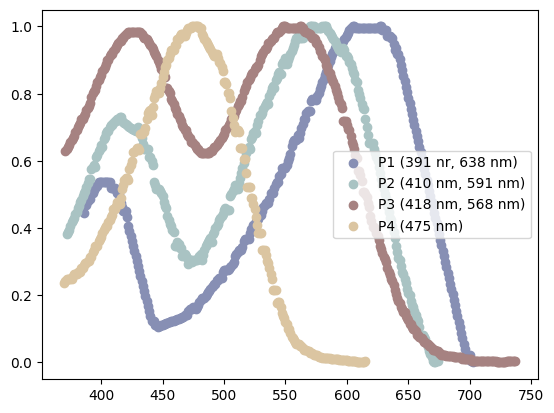

In [549]:
for i in new_dict.keys():
  #print(i)
  df = pd.concat([pd.DataFrame(new_dict[i][0], columns=['wavelength']), pd.DataFrame(min_max_scaler.fit_transform(-1*new_dict[i][1].reshape(-1, 1)), columns=['absor'])], axis=1 )
  df.dropna(axis=0)#
  plt.scatter(df.wavelength.values+x_bias+50, df.absor.values, label=i, color=list(dict_1_norm[i]))
  plt.legend()
  
  
  #ax.set_xlim([np.min([int(tick[0][:3]) for tick in results]), np.max([int(tick[0][:3]) for tick in results])]) 

  # plt.xlim(np.min([int(tick[0][:3]) for tick in results]), np.max([int(tick[0][:3]) for tick in results]))
  #try:
  #df.to_csv('%s.csv'%i, index=None)

  #df.to_csv(os.path.join(path_save,'%s.csv'%i), index=None)
  #except:

   # pass

In [571]:
result["visual"][0]

array([[[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       ...,

       [[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0